In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

23/10/07 12:46:32 WARN Utils: Your hostname, luxiangnandeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.126 instead (on interface en0)
23/10/07 12:46:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/07 12:46:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [128]:
pip install graphviz py4j

Note: you may need to restart the kernel to use updated packages.


In [133]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = spark.read.option("delimiter", ";").csv('cardio_train.csv', inferSchema=True, header=True)

In [3]:
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql.functions import corr

In [87]:
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier, 
                                       RandomForestClassifier, GBTClassifier, LinearSVC, MultilayerPerceptronClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [4]:
df.show()

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|21914|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|22113|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12|22584|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13|17668|     1|   158|  71.0|  110|   70

In [5]:
df_1=spark.read.csv('cardiovascular-disease-death-rates.csv', inferSchema=True, header=True)
df_1.show()

+-----------+----+----+---------------------------------------------------------------------------+
|     Entity|Code|Year|Deaths - Cardiovascular diseases - Sex: Both - Age: Age-standardized (Rate)|
+-----------+----+----+---------------------------------------------------------------------------+
|Afghanistan| AFG|1990|                                                                     716.27|
|Afghanistan| AFG|1991|                                                                      711.2|
|Afghanistan| AFG|1992|                                                                     708.28|
|Afghanistan| AFG|1993|                                                                     712.87|
|Afghanistan| AFG|1994|                                                                     720.74|
|Afghanistan| AFG|1995|                                                                      724.0|
|Afghanistan| AFG|1996|                                                                      727.4|


In [6]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [7]:
summary_pd = df.describe().toPandas()

percentiles = [0.25, 0.5, 0.75]
percentile_values = {col: df.approxQuantile(col, percentiles, 0.05) for col in df.columns}
percentiles_pd = pd.DataFrame(percentile_values, index=[f'{p*100}%' for p in percentiles])
summary_pd = summary_pd.set_index('summary').transpose()
percentiles_pd = percentiles_pd.transpose()

final_df = pd.concat([summary_pd, percentiles_pd], axis=1)

print(final_df)

23/10/07 12:46:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


             count                  mean               stddev    min    max  \
id           70000            49972.4199   28851.302323172742      0  99999   
age          70000    19468.865814285713    2467.251667241397  10798  23713   
gender       70000    1.3495714285714286  0.47683801558286265      1      2   
height       70000    164.35922857142856    8.210126364538075     55    250   
weight       70000              74.20569   14.395756678511347   10.0  200.0   
ap_hi        70000     128.8172857142857    154.0114194560919   -150  16020   
ap_lo        70000     96.63041428571428   188.47253029638918    -70  11000   
cholesterol  70000    1.3668714285714285   0.6802503486993823      1      3   
gluc         70000     1.226457142857143   0.5722702766138456      1      3   
smoke        70000   0.08812857142857143  0.28348381676993667      0      1   
alco         70000  0.053771428571428574  0.22556770360410555      0      1   
active       70000    0.8037285714285715   0.3971790

In [8]:
df.select('age').show()

+-----+
|  age|
+-----+
|18393|
|20228|
|18857|
|17623|
|17474|
|21914|
|22113|
|22584|
|17668|
|19834|
|22530|
|18815|
|14791|
|19809|
|14532|
|16782|
|21296|
|16747|
|17482|
|21755|
+-----+
only showing top 20 rows



In [9]:
df = df.withColumn('age', (F.round(df['age'] / 365)).cast('int'))
df.show()

+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8| 60|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9| 61|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 12| 62|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 13| 48|     1|   158|  71.0|  110|   70|          1|   1|    0|

In [10]:
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

matrix = Correlation.corr(df_vector, "features")


corr_matrix = matrix.head()[0].toArray()
corr_df = pd.DataFrame(corr_matrix, index=df.columns, columns=df.columns)


corr_df_rounded = corr_df.round(2)

print(corr_df_rounded)

               id   age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
id           1.00  0.00    0.00   -0.00   -0.00   0.00  -0.00         0.01   
age          0.00  1.00   -0.02   -0.08    0.05   0.02   0.02         0.15   
gender       0.00 -0.02    1.00    0.50    0.16   0.01   0.02        -0.04   
height      -0.00 -0.08    0.50    1.00    0.29   0.01   0.01        -0.05   
weight      -0.00  0.05    0.16    0.29    1.00   0.03   0.04         0.14   
ap_hi        0.00  0.02    0.01    0.01    0.03   1.00   0.02         0.02   
ap_lo       -0.00  0.02    0.02    0.01    0.04   0.02   1.00         0.02   
cholesterol  0.01  0.15   -0.04   -0.05    0.14   0.02   0.02         1.00   
gluc         0.00  0.10   -0.02   -0.02    0.11   0.01   0.01         0.45   
smoke       -0.00 -0.05    0.34    0.19    0.07  -0.00   0.01         0.01   
alco         0.00 -0.03    0.17    0.09    0.07   0.00   0.01         0.04   
active       0.00 -0.01    0.01   -0.01   -0.02  -0.00   0.00   

23/10/07 12:46:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/07 12:46:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [11]:
pandas_df = df.toPandas()

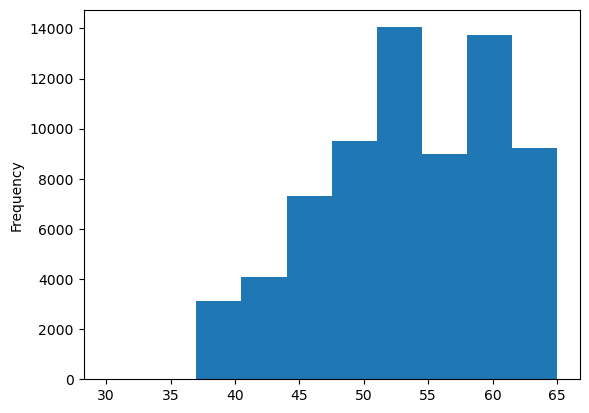

In [12]:
pandas_df['age'].plot.hist()
plt.show()

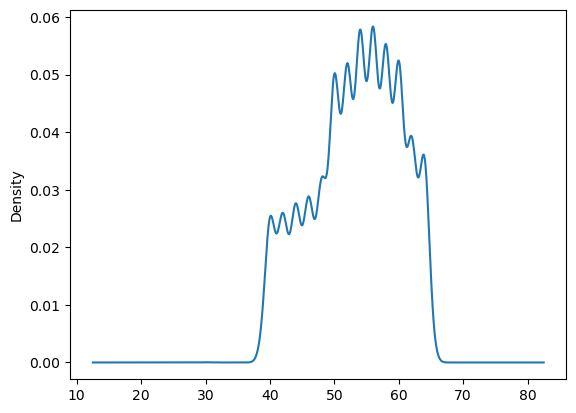

In [13]:
pandas_df['age'].plot.density()
plt.show()

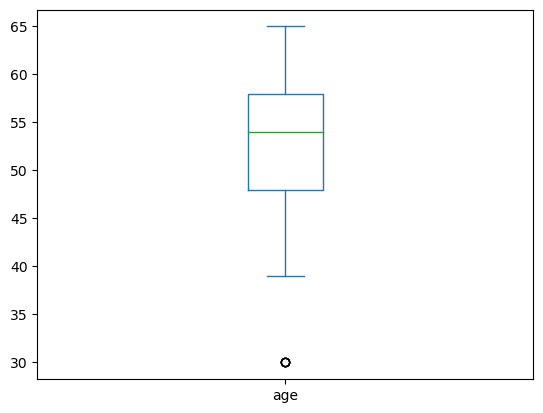

In [14]:
pandas_df['age'].plot.box()
plt.show()

In [15]:
def outliers(spark_df, columns, drop=False):
    for each_feature in columns:
        bounds = spark_df.approxQuantile(each_feature, [0.25, 0.75], 0.05)
        Q1, Q3 = bounds
        IQR = Q3 - Q1

        outliers_condition = ~((spark_df[each_feature] >= Q1 - 1.5 * IQR) & (spark_df[each_feature] <= Q3 + 1.5 * IQR))
        spark_df = spark_df.withColumn(f'{each_feature}_outlier', outliers_condition.cast('int'))

        outliers_df = spark_df.filter(outliers_condition)
        print(f'For the feature {each_feature}, No of Outliers is {outliers_df.count()}')

    outlier_flag_sum = sum([F.col(f'{each_feature}_outlier') for each_feature in columns])
    spark_df = spark_df.withColumn('outlier_flag_sum', outlier_flag_sum)
    total_unique_outliers = spark_df.filter(spark_df['outlier_flag_sum'] > 0).count()
    print(f'Total number of unique outliers: {total_unique_outliers}')

    if drop:
        non_outliers_condition = spark_df['outlier_flag_sum'] == 0
        spark_df = spark_df.filter(non_outliers_condition)
        print('Outliers removed.')
    for each_feature in columns:
        spark_df = spark_df.drop(f'{each_feature}_outlier')
    spark_df = spark_df.drop('outlier_flag_sum')

    return spark_df
outliers_df = outliers(df, ['height', 'weight'], drop=False)

For the feature height, No of Outliers is 901
For the feature weight, No of Outliers is 2992
Total number of unique outliers: 3742


In [16]:
negative_ap_lo_df = df.filter(df['ap_lo'] < 0)
negative_ap_lo_pd = negative_ap_lo_df.toPandas()
transposed_negative_ap_lo = negative_ap_lo_pd.transpose()
print(transposed_negative_ap_lo)

                   0
id           85816.0
age             62.0
gender           1.0
height         167.0
weight          74.0
ap_hi           15.0
ap_lo          -70.0
cholesterol      1.0
gluc             1.0
smoke            0.0
alco             0.0
active           1.0
cardio           1.0


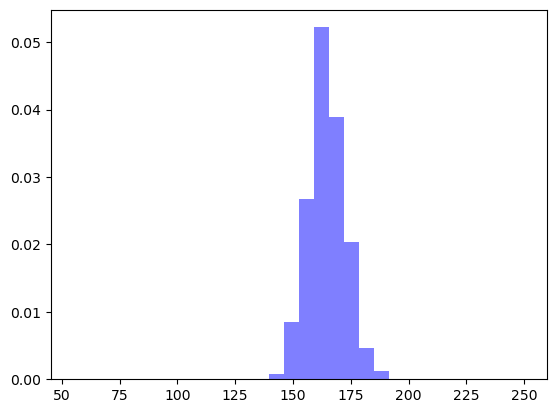

In [17]:
heightArr = np.array(df.select('height').collect())
plt.hist(heightArr, bins=30, density=True, alpha=0.5, color='blue')
plt.show()

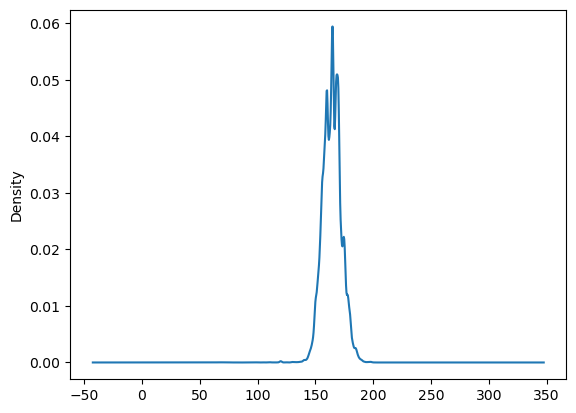

In [18]:
pandas_df['height'].plot.density()
plt.show()

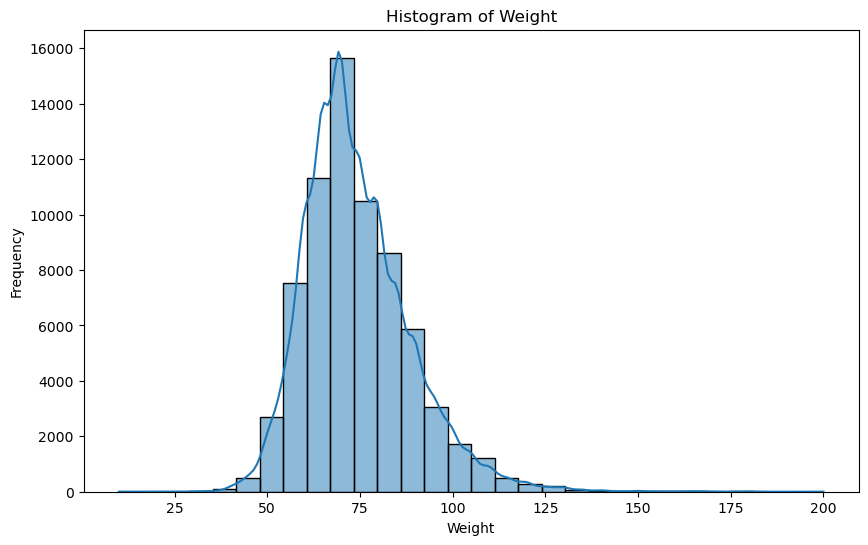

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['weight'], bins=30, kde=True)
plt.title('Histogram of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

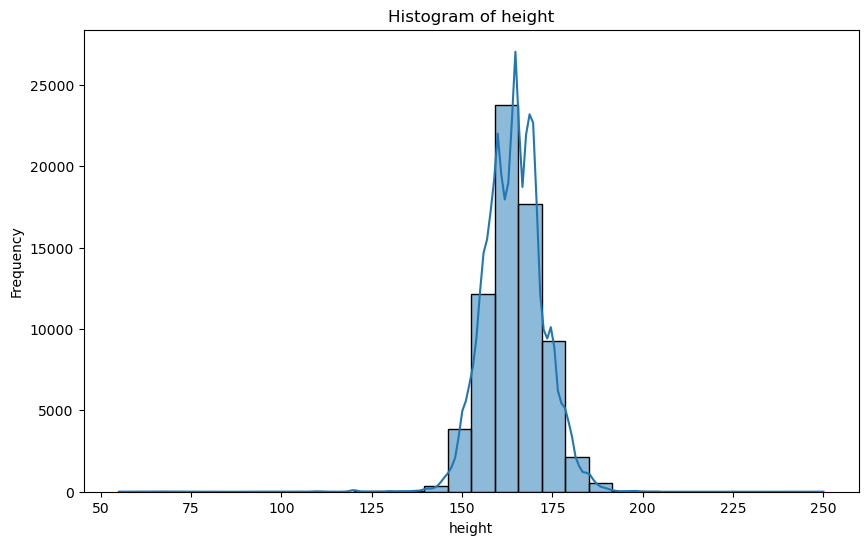

In [20]:
#histogram graph of height

plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['height'], bins=30, kde=True)
plt.title('Histogram of height')
plt.xlabel('height')
plt.ylabel('Frequency')
plt.show()

In [21]:
df = df.drop('id')

In [22]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



In [23]:
outliers(df, ['height', 'weight'], drop=True)

For the feature height, No of Outliers is 901
For the feature weight, No of Outliers is 2992
Total number of unique outliers: 3742
Outliers removed.


DataFrame[age: int, gender: int, height: int, weight: double, ap_hi: int, ap_lo: int, cholesterol: int, gluc: int, smoke: int, alco: int, active: int, cardio: int]

In [24]:
weight_quantiles = df.approxQuantile("weight", [0.005, 0.995], 0.0)

df = df.filter((df['weight'] > weight_quantiles[0]) & (df['weight'] < weight_quantiles[1]))

height_quantiles = df.approxQuantile("height", [0.005, 0.995], 0.0)

df = df.filter((df['height'] > height_quantiles[0]) & (df['height'] < height_quantiles[1]))

In [25]:
outliers(df, ['height', 'weight'], drop=False)
num_rows = df.count()
print(f'The DataFrame has {num_rows} rows.')

For the feature height, No of Outliers is 669
For the feature weight, No of Outliers is 2356
Total number of unique outliers: 2940
The DataFrame has 68370 rows.


In [26]:
pandas_df_free = df.toPandas()

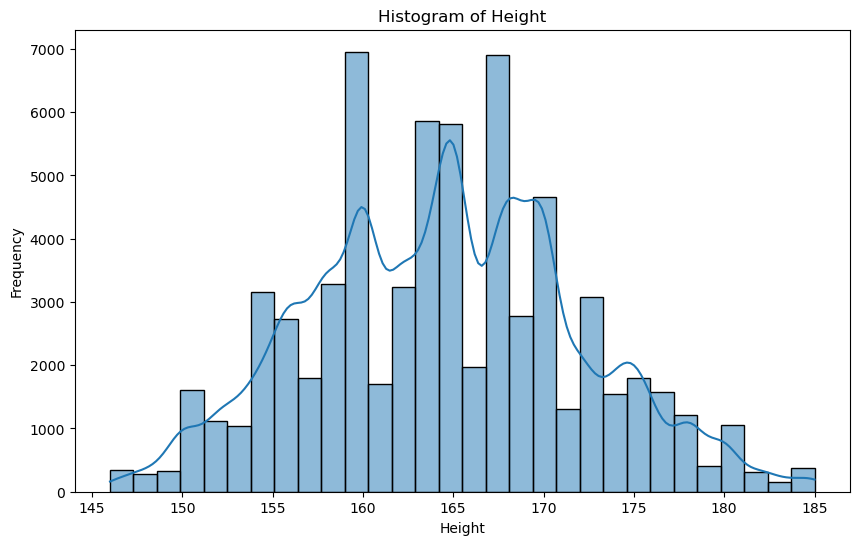

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df_free['height'], bins=30, kde=True)
plt.title('Histogram of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

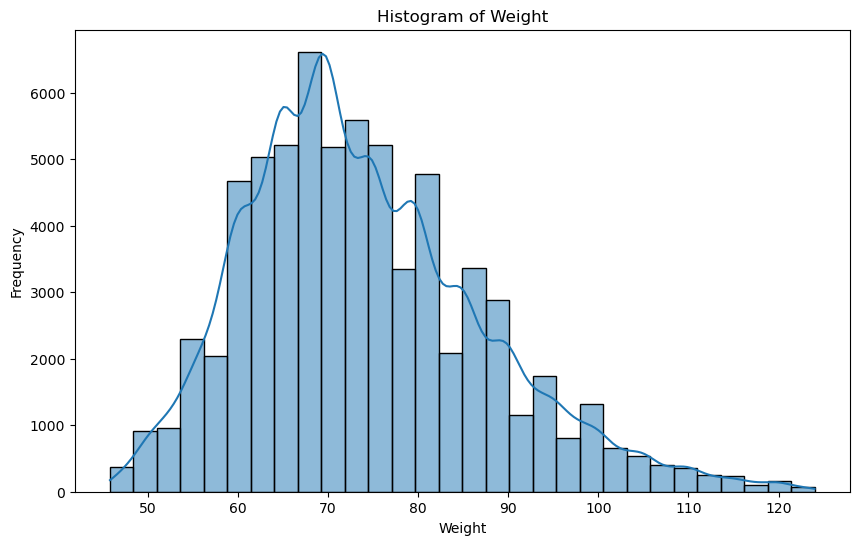

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df_free['weight'], bins=30, kde=True)
plt.title('Histogram of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

In [29]:
df.filter((df['ap_hi'] < 0) | (df['ap_lo'] < 0)).show()

negative_bp_df = df.filter((df['ap_hi'] < 0) | (df['ap_lo'] < 0))

print(f"Total number of records with negative blood pressure: {negative_bp_df.count()}")

outlier_free_df = df.withColumn('ap_hi', F.abs(df['ap_hi'])).\
                withColumn('ap_lo', F.abs(df['ap_lo']))




+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 42|     1|   165|  78.0| -100|   80|          2|   1|    0|   0|     1|     0|
| 61|     2|   161|  90.0| -115|   70|          1|   1|    0|   0|     1|     0|
| 43|     1|   153|  54.0| -100|   70|          1|   1|    0|   0|     1|     0|
| 50|     1|   162|  74.0| -140|   90|          1|   1|    0|   0|     1|     1|
| 40|     2|   168|  50.0| -120|   80|          2|   1|    0|   0|     0|     1|
| 64|     2|   168|  59.0| -150|   80|          1|   1|    0|   0|     1|     1|
| 65|     2|   160|  59.0| -120|   80|          1|   1|    0|   0|     0|     0|
| 62|     1|   167|  74.0|   15|  -70|          1|   1|    0|   0|     1|     1|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+

Total number of records wit

In [30]:
print(f"Total number of records with negative blood pressure: \
      {outlier_free_df.filter((outlier_free_df['ap_hi'] < 0) | (outlier_free_df['ap_lo'] < 0)).count()}")


Total number of records with negative blood pressure:       0


In [31]:
print("Records with abnormal pairs in blood pressure attributes:")
abnormal_df = df.filter(df['ap_hi'] < df['ap_lo'])
abnormal_df.show()
print("Total number of abnormal pairs:")
print(abnormal_df.count())

Records with abnormal pairs in blood pressure attributes:
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 48|     2|   183|  98.0|  160| 1100|          1|   2|    1|   0|     1|     1|
| 60|     2|   157|  60.0|  160| 1000|          2|   1|    0|   0|     0|     1|
| 50|     1|   150|  83.0|  140|  800|          1|   1|    0|   0|     1|     1|
| 64|     1|   176|  63.0|  160| 1000|          2|   2|    0|   0|     0|     1|
| 51|     1|   154|  81.0|  140| 1000|          2|   1|    0|   0|     1|     1|
| 42|     1|   150|  95.0|  150| 1033|          1|   1|    0|   0|     1|     1|
| 52|     1|   156|  65.0|  120|  150|          2|   1|    0|   0|     1|     0|
| 56|     2|   173| 101.0|  200| 1000|          1|   1|    0|   0|     1|     1|
| 58|     1|   168|  78.0|   14|   90|          2| 

In [32]:
df.count()

68370

In [33]:
df = df.filter(df['ap_hi'] >= df['ap_lo'])
df.count()

67181

In [34]:
#limmer the upper bound of high and low blood pressure

# Keep only rows where ap_hi <= 250 and ap_lo <= 200
df = df.filter((df['ap_hi'] <= 250) & (df['ap_lo'] <= 200))
df.show(8)
df.count()

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
| 60|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
| 61|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 62|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 8 rows



67143

In [35]:
from pyspark.sql import Window
# Find duplicate rows

window_spec = Window.partitionBy('gender', 'height', 'weight', 'age').orderBy('gender', 'height', 'weight', 'age')
duplicated = df.withColumn('count', F.count('*').over(window_spec)).filter('count > 1').drop('count')
duplicated.show(5)


+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 58|     1|   146|  52.0|  120|   80|          1|   1|    0|   0|     1|     0|
| 58|     1|   146|  52.0|  120|   80|          1|   1|    0|   0|     1|     1|
| 58|     1|   146|  52.0|  120|   80|          1|   1|    0|   0|     1|     0|
| 56|     1|   146|  54.0|  110|   70|          1|   1|    0|   0|     1|     0|
| 56|     1|   146|  54.0|  120|   80|          1|   1|    0|   0|     1|     0|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



In [36]:
df =df.toPandas().drop_duplicates(keep='first')

df = spark.createDataFrame(df)

In [37]:
df.count()

63331

In [38]:
df.show()

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
| 60|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
| 61|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|
| 62|     2|   178|  95.0|  130|   90|          3|   3|    0|   0|     1|     1|
| 48|     1|   158|  71.0|  110|   70|          1|   1|    0|   0|     1|     0|
| 54|     1|   164|  68.0|  

In [39]:
from pyspark.sql.functions import col
from pyspark.sql.functions import round

df = df.withColumn('BMI', 
    col('weight') / ((col('height') / 100) ** 2)
)
df = df.withColumn('BMI', 
    round(col('BMI'), 2)
)
df.show(5)


+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|
| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|
| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|
| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|
| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+
only showing top 5 rows



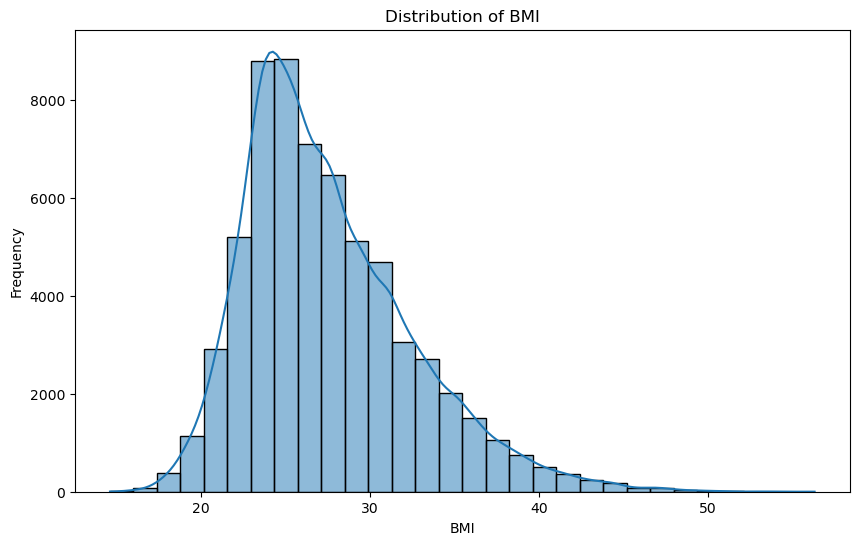

In [40]:

bmi_series = df.select("BMI").toPandas()["BMI"]

plt.figure(figsize=(10, 6))
sns.histplot(bmi_series, kde=True, bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()


In [41]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obese'


categorize_bmi_udf = udf(categorize_bmi, StringType())
df = df.withColumn("BMI_Category", categorize_bmi_udf(df["BMI"]))
df.show()


+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|BMI_Category|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+
| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|      Normal|
| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|       Obese|
| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|      Normal|
| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|  Overweight|
| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|      Normal|
| 60|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.38|  Overweight|
| 61|     1|   157|  93.0|  130|   80|          3|   1|    0|   0|     1|     0|37.73|       Obese|


PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got float64.

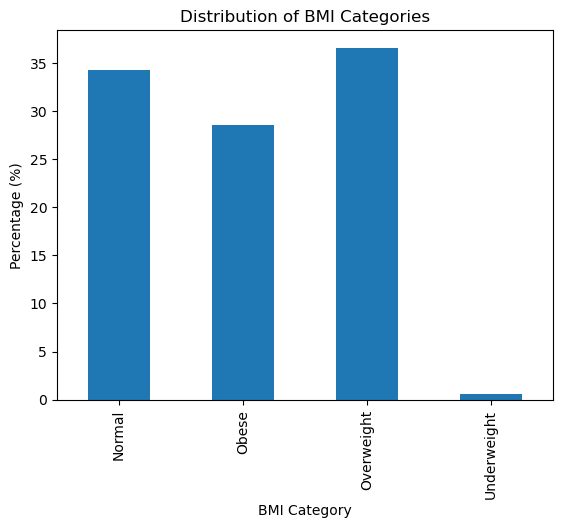

In [42]:
from pyspark.sql.functions import count, lit

# 1. Get frequency counts of each category
count_df = df.groupBy("BMI_Category").agg(count("*").alias("count")).orderBy("BMI_Category")

# Convert to Pandas DataFrame for further processing
count_pdf = count_df.toPandas()
count_pdf.set_index("BMI_Category", inplace=True)

# 2. Convert to percentages
total = df.count()
count_pdf["percentage"] = (count_pdf["count"] / total) * 100

# 3. Plotting
ax = count_pdf["percentage"].plot(kind='bar')
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Percentage (%)')

# Annotating with percentage values
for idx, (category, row) in enumerate(count_pdf.iterrows()):
    ax.text(idx, row["percentage"], f"{str(round(row['percentage'], 2))}% ({row['count']})")

plt.show()


In [43]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define the age grouping function
def age_grouping(age):
    if age < 40:
        return "Below 40"
    elif 40 <= age < 50:
        return "40-50"
    elif 50 <= age < 60:
        return "50-60"
    else:
        return "Above 60"

# Convert the Python function to a UDF
age_grouping_udf = udf(age_grouping, StringType())

# Apply the UDF to the DataFrame
df = df.withColumn("age_group", age_grouping_udf(df["age"]))

# Show the DataFrame
df.show()



+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|BMI_Category|age_group|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|      Normal|    50-60|
| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|       Obese|    50-60|
| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|      Normal|    50-60|
| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|  Overweight|    40-50|
| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|      Normal|    40-50|
| 60|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.38|  Overweight| Above 60|
| 61|     

PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got float64.

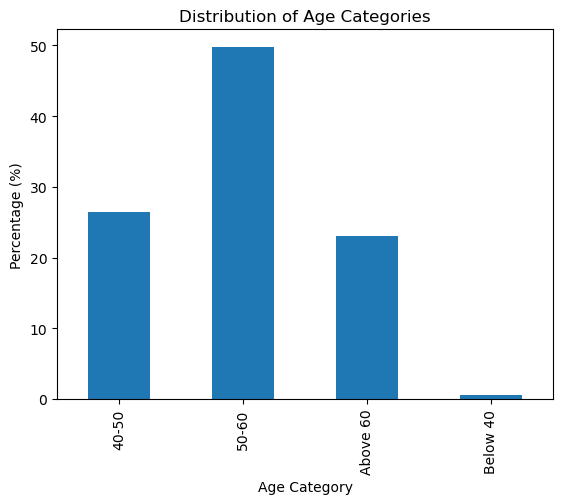

In [44]:
from pyspark.sql.functions import count
count_df = df.groupBy("age_group").agg(count("*").alias("count")).orderBy("age_group")
count_pdf = count_df.toPandas()
count_pdf.set_index("age_group", inplace=True)
total = df.count()
count_pdf["percentage"] = (count_pdf["count"] / total) * 100
ax = count_pdf["percentage"].plot(kind='bar')
plt.title('Distribution of Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Percentage (%)')
for idx, (category, row) in enumerate(count_pdf.iterrows()):
    ax.text(idx, row["percentage"], f"{str(round(row['percentage'], 2))}% ({row['count']})")

plt.show()


In [45]:
df_2 = spark.read.csv('framingham_.csv', header=True, inferSchema=True)

df_2.printSchema()
df_2.count()

root
 |-- gender: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: double (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: double (nullable = true)
 |-- BPMeds: double (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: integer (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- heartRate: double (nullable = true)
 |-- glucose: double (nullable = true)
 |-- TenYearCHD: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)



4240

In [46]:
from pyspark.sql.functions import col, sum

for column in df_2.columns:
    null_count = df_2.filter(col(column).isNull()).count()
    print(f"The column '{column}' has {null_count} null values.")


The column 'gender' has 0 null values.
The column 'age' has 0 null values.
The column 'education' has 105 null values.
The column 'currentSmoker' has 0 null values.
The column 'cigsPerDay' has 29 null values.
The column 'BPMeds' has 53 null values.
The column 'prevalentStroke' has 0 null values.
The column 'prevalentHyp' has 0 null values.
The column 'diabetes' has 0 null values.
The column 'totChol' has 50 null values.
The column 'sysBP' has 0 null values.
The column 'diaBP' has 0 null values.
The column 'BMI' has 19 null values.
The column 'heartRate' has 1 null values.
The column 'glucose' has 388 null values.
The column 'TenYearCHD' has 0 null values.
The column 'alco' has 0 null values.
The column 'active' has 0 null values.


In [47]:
condition = None
for column in df_2.columns:
    current_condition = col(column).isNull()
    if condition is None:
        condition = current_condition
    else:
        condition = condition | current_condition

# Use the condition to filter the DataFrame and count the rows
null_rows_count = df_2.filter(condition).count()

print(f"There are {null_rows_count} rows with at least one null value.")

There are 582 rows with at least one null value.


In [48]:
df_2 = df_2.dropna()

print(df_2.count())


3658


In [49]:
new_df = df_2.withColumnRenamed('sysBP', 'ap_hi')\
             .withColumnRenamed('diaBP', 'ap_lo')\
             .withColumnRenamed('currentSmoker', 'smoke')\
             .withColumnRenamed('totChol', 'cholesterol')\
             .withColumnRenamed('glucose', 'gluc')\
             .withColumnRenamed('TenYearCHD', 'cardio')

columns_to_drop = ['education', 'BPMeds', 'prevalentStroke',\
                   'prevalentHyp', 'diabetes', 'heartRate', 'cigsPerDay']
new_df = new_df.drop(*columns_to_drop)

new_df = new_df.withColumn("age_group", age_grouping_udf(new_df["age"]))

categorize_bmi_udf = udf(categorize_bmi, StringType())
new_df = new_df.withColumn("BMI_Category", categorize_bmi_udf(new_df["BMI"]))

new_df.show


<bound method DataFrame.show of DataFrame[gender: int, age: int, smoke: int, cholesterol: int, ap_hi: double, ap_lo: double, BMI: double, gluc: double, cardio: int, alco: int, active: int, age_group: string, BMI_Category: string]>

In [50]:
new_df.count()
df.count()

63331

In [51]:
df.show()

+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
|age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|BMI_Category|age_group|
+---+------+------+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
| 50|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|21.97|      Normal|    50-60|
| 55|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|34.93|       Obese|    50-60|
| 52|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|23.51|      Normal|    50-60|
| 48|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|28.71|  Overweight|    40-50|
| 48|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|23.01|      Normal|    40-50|
| 60|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|29.38|  Overweight| Above 60|
| 61|     

In [52]:
df = df.drop('height', 'weight')

In [53]:

column_order = df.columns
new_df = new_df.select(*column_order)

combined_df = df.union(new_df)

print("\nInfo for combined_df:")
combined_df.printSchema()
combined_df.count()



Info for combined_df:
root
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: double (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- BMI_Category: string (nullable = true)
 |-- age_group: string (nullable = true)



66989

In [54]:
def custom_print_schema(df):
    schema_strs = df.schema.simpleString().replace("struct<", "").replace(">", "").split(",")
    print("root")
    for idx, column_info in enumerate(schema_strs, start=1):
        print(f" |-- {idx}: {column_info.strip()}")
        
custom_print_schema(combined_df)


root
 |-- 1: age:bigint
 |-- 2: gender:bigint
 |-- 3: ap_hi:double
 |-- 4: ap_lo:double
 |-- 5: cholesterol:bigint
 |-- 6: gluc:double
 |-- 7: smoke:bigint
 |-- 8: alco:bigint
 |-- 9: active:bigint
 |-- 10: cardio:bigint
 |-- 11: BMI:double
 |-- 12: BMI_Category:string
 |-- 13: age_group:string


In [55]:
from pyspark.sql.functions import when
combined_df = combined_df.withColumn("BMI", round(col("BMI"), 2))

combined_df = combined_df.withColumn(
    "age_group",
    when(col("age_group") == "Below 40", "<40")
    .when(col("age_group") == "Above 60", "60+")
    .otherwise(col("age_group"))
)

print("\nSchema after renaming categories:")
combined_df.printSchema()

combined_df.show()



Schema after renaming categories:
root
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: double (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- BMI_Category: string (nullable = true)
 |-- age_group: string (nullable = true)

+---+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
|age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|BMI_Category|age_group|
+---+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
| 50|     2|110.0| 80.0|          1| 1.0|    0|   0|     1|     0|21.97|      Normal|    50-60|
| 55|     1|140.0| 90.0|          3| 1.0|    0|   0|     1|     1|34.93|       Obese|    50-60

In [56]:
combined_df.show()

+---+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
|age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|BMI_Category|age_group|
+---+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+
| 50|     2|110.0| 80.0|          1| 1.0|    0|   0|     1|     0|21.97|      Normal|    50-60|
| 55|     1|140.0| 90.0|          3| 1.0|    0|   0|     1|     1|34.93|       Obese|    50-60|
| 52|     1|130.0| 70.0|          3| 1.0|    0|   0|     0|     1|23.51|      Normal|    50-60|
| 48|     2|150.0|100.0|          1| 1.0|    0|   0|     1|     1|28.71|  Overweight|    40-50|
| 48|     1|100.0| 60.0|          1| 1.0|    0|   0|     0|     0|23.01|      Normal|    40-50|
| 60|     1|120.0| 80.0|          2| 2.0|    0|   0|     0|     0|29.38|  Overweight|      60+|
| 61|     1|130.0| 80.0|          3| 1.0|    0|   0|     1|     0|37.73|       Obese|      60+|
| 62|     2|130.0| 90.0|          3| 3.0

In [57]:
# Count rows for each category in the 'BMI_Category' column
combined_df.groupBy("BMI_Category").count().orderBy("BMI_Category").show()


+------------+-----+
|BMI_Category|count|
+------------+-----+
|      Normal|23320|
|       Obese|18576|
|  Overweight|24683|
| Underweight|  410|
+------------+-----+



In [58]:
combined_df.printSchema()


root
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: double (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- BMI_Category: string (nullable = true)
 |-- age_group: string (nullable = true)



In [65]:
from pyspark.ml.feature import StringIndexer

bmi_indexer = StringIndexer(inputCol="BMI_Category", outputCol="BMI_Category_indexed")
age_group_indexer = StringIndexer(inputCol="age_group", outputCol="age_group_indexed")

bmi_model = bmi_indexer.fit(combined_df)
age_group_model = age_group_indexer.fit(combined_df)

combined_df_indexed = bmi_model.transform(combined_df)
combined_df_indexed = age_group_model.transform(combined_df_indexed)

In [66]:
combined_df_indexed.printSchema()

root
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: double (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- BMI_Category: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- BMI_Category_indexed: double (nullable = false)
 |-- age_group_indexed: double (nullable = false)



In [67]:
combined_df_indexed.show()

+---+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+--------------------+-----------------+
|age|gender|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|  BMI|BMI_Category|age_group|BMI_Category_indexed|age_group_indexed|
+---+------+-----+-----+-----------+----+-----+----+------+------+-----+------------+---------+--------------------+-----------------+
| 50|     2|110.0| 80.0|          1| 1.0|    0|   0|     1|     0|21.97|      Normal|    50-60|                 1.0|              0.0|
| 55|     1|140.0| 90.0|          3| 1.0|    0|   0|     1|     1|34.93|       Obese|    50-60|                 2.0|              0.0|
| 52|     1|130.0| 70.0|          3| 1.0|    0|   0|     0|     1|23.51|      Normal|    50-60|                 1.0|              0.0|
| 48|     2|150.0|100.0|          1| 1.0|    0|   0|     1|     1|28.71|  Overweight|    40-50|                 0.0|              1.0|
| 48|     1|100.0| 60.0|          1| 1.0|    0|   0|   

In [68]:
# For BMI_Category
bmi_labels = bmi_model.labels
for i, label in enumerate(bmi_labels):
    print(f"{label} -> {i}")

print("\n")

# For age_group
age_group_labels = age_group_model.labels
for i, label in enumerate(age_group_labels):
    print(f"{label} -> {i}")


Overweight -> 0
Normal -> 1
Obese -> 2
Underweight -> 3


50-60 -> 0
40-50 -> 1
60+ -> 2
<40 -> 3


In [69]:
correlations = [(column, combined_df_indexed.stat.corr(column, "cardio")) 
                for column in combined_df_indexed.columns 
                if column not in ["cardio", "BMI_Category", "age_group"]]

sorted_correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

for column, correlation_value in sorted_correlations:
    print(f"{column}: {correlation_value}")

ap_hi: 0.39294852274538766
ap_lo: 0.31153400933311326
age: 0.24987807399892312
BMI: 0.18859091209366277
cholesterol: 0.16661768661975454
gender: 0.0671945157709164
BMI_Category_indexed: 0.06716867777522958
age_group_indexed: 0.048315110684570416
active: -0.0019623512799934115
smoke: -0.06677000280984675
alco: -0.07460478826925399
gluc: -0.1465766833719329


root
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: double (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- BMI_Category: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- BMI_Category_indexed: double (nullable = false)
 |-- age_group_indexed: double (nullable = false)
 |-- log_BMI: double (nullable = true)



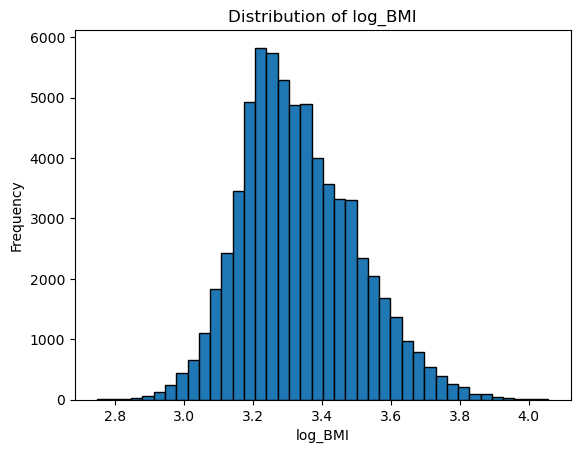

In [70]:
from pyspark.sql.functions import log1p

combined_df_indexed = combined_df_indexed.withColumn("log_BMI", log1p(combined_df["BMI"]))
combined_df_indexed.printSchema()

log_BMI_data = combined_df_indexed.select('log_BMI').rdd.flatMap(lambda x: x).collect()

plt.hist(log_BMI_data, bins=40, edgecolor='black')
plt.xlabel('log_BMI')
plt.ylabel('Frequency')
plt.title('Distribution of log_BMI')
plt.show()


In [71]:
assembler = VectorAssembler(
    inputCols=["age", "gender","ap_hi","ap_lo",
               "cholesterol","BMI_Category_indexed","age_group_indexed","log_BMI","BMI"],
    outputCol="features")

In [72]:
output = assembler.transform(combined_df_indexed)

In [73]:
output.printSchema()
output.head(1)

root
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- ap_hi: double (nullable = true)
 |-- ap_lo: double (nullable = true)
 |-- cholesterol: long (nullable = true)
 |-- gluc: double (nullable = true)
 |-- smoke: long (nullable = true)
 |-- alco: long (nullable = true)
 |-- active: long (nullable = true)
 |-- cardio: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- BMI_Category: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- BMI_Category_indexed: double (nullable = false)
 |-- age_group_indexed: double (nullable = false)
 |-- log_BMI: double (nullable = true)
 |-- features: vector (nullable = true)



[Row(age=50, gender=2, ap_hi=110.0, ap_lo=80.0, cholesterol=1, gluc=1.0, smoke=0, alco=0, active=1, cardio=0, BMI=21.97, BMI_Category='Normal', age_group='50-60', BMI_Category_indexed=1.0, age_group_indexed=0.0, log_BMI=3.134189016701007, features=DenseVector([50.0, 2.0, 110.0, 80.0, 1.0, 1.0, 0.0, 3.1342, 21.97]))]

In [74]:
final_data = output.select("features",'cardio')
final_data.show()

+--------------------+------+
|            features|cardio|
+--------------------+------+
|[50.0,2.0,110.0,8...|     0|
|[55.0,1.0,140.0,9...|     1|
|[52.0,1.0,130.0,7...|     1|
|[48.0,2.0,150.0,1...|     1|
|[48.0,1.0,100.0,6...|     0|
|[60.0,1.0,120.0,8...|     0|
|[61.0,1.0,130.0,8...|     0|
|[62.0,2.0,130.0,9...|     1|
|[48.0,1.0,110.0,7...|     0|
|[54.0,1.0,110.0,6...|     0|
|[62.0,1.0,120.0,8...|     0|
|[52.0,2.0,120.0,8...|     0|
|[41.0,2.0,120.0,8...|     0|
|[54.0,1.0,110.0,7...|     0|
|[40.0,2.0,130.0,9...|     0|
|[46.0,2.0,120.0,8...|     1|
|[58.0,1.0,130.0,7...|     0|
|[46.0,1.0,110.0,7...|     0|
|[48.0,1.0,100.0,7...|     0|
|[60.0,2.0,120.0,7...|     0|
+--------------------+------+
only showing top 20 rows



In [70]:
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier, 
                                       RandomForestClassifier, GBTClassifier, LinearSVC, MultilayerPerceptronClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

classifiers = {
    "Logistic Regression": LogisticRegression(labelCol='cardio'),
    "Support Vector Classifier": LinearSVC(labelCol='cardio'),
    "Decision Tree": DecisionTreeClassifier(labelCol='cardio'),
    "Random Forest": RandomForestClassifier(labelCol='cardio'),
    "Gradient-Boosted Trees": GBTClassifier(labelCol='cardio')
}

layers = [len(final_data.select("features").first()[0]), 5, 4, 2]
classifiers["Multilayer Perceptron"] = MultilayerPerceptronClassifier(labelCol='cardio', layers=layers, blockSize=128, maxIter=100)

accuracies = {}

evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")

for name, clf in classifiers.items():
    model = clf.fit(final_data)
    predictions = model.transform(final_data)
    accuracy = evaluator.evaluate(predictions)
    accuracies[name] = accuracy

from pyspark.sql import Row
rows = [Row(Classifier=name, Accuracy=accuracy) for name, accuracy in accuracies.items()]
df_accuracies = spark.createDataFrame(rows)

df_accuracies.show()


+--------------------+------------------+
|          Classifier|          Accuracy|
+--------------------+------------------+
| Logistic Regression|0.7080565465972025|
|Support Vector Cl...|0.7117586469420353|
|       Decision Tree|0.7245219364373255|
|       Random Forest|0.7265073370254818|
|Gradient-Boosted ...|0.7341503828986848|
|Multilayer Percep...|0.5109197032348595|
+--------------------+------------------+



In [71]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Train a linear regression model
lr = LinearRegression(featuresCol='features', labelCol='cardio')
lr_model = lr.fit(final_data)

# Make predictions
predictions = lr_model.transform(final_data)

# Evaluate the model using R^2 metric
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="cardio", metricName="r2")
r2 = evaluator.evaluate(predictions)

print(f"R^2 value for the Linear Regression model: {r2}")


23/10/07 12:39:43 WARN Instrumentation: [8a893d3b] regParam is zero, which might cause numerical instability and overfitting.
23/10/07 12:39:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


R^2 value for the Linear Regression model: 0.200743867755093


In [72]:
# Initialize the SVM classifier
svc = LinearSVC(labelCol='cardio')

# Train the model
svc_model = svc.fit(final_data)

# Make predictions
predictions_svc = svc_model.transform(final_data)

In [73]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Area Under ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="cardio")
auc = binary_evaluator.evaluate(predictions_svc, {binary_evaluator.metricName: "areaUnderROC"})

# Area Under PR Curve
pr = binary_evaluator.evaluate(predictions_svc, {binary_evaluator.metricName: "areaUnderPR"})

# Accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy = multi_evaluator.evaluate(predictions_svc)

# Weighted Precision
weighted_precision = multi_evaluator.evaluate(predictions_svc, {multi_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
weighted_recall = multi_evaluator.evaluate(predictions_svc, {multi_evaluator.metricName: "weightedRecall"})

# F1 Score
f1 = multi_evaluator.evaluate(predictions_svc, {multi_evaluator.metricName: "f1"})

# Create a confusion matrix
true_positives = predictions.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
true_negatives = predictions.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
false_positives = predictions.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
false_negatives = predictions.filter((col("cardio") == 1) & (col("prediction") == 0)).count()

print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(true_positives, false_positives))
print("Predicted Negative\t{}\t\t{}".format(false_negatives, true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {auc}")
print(f"Area Under PR Curve: {pr}")
print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")


Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	0		0
Predicted Negative	0		0
----------------------------------------
Area Under ROC (AUC): 0.7726122437113406
Area Under PR Curve: 0.7361512293764404
Accuracy: 0.7117586469420353
Weighted Precision: 0.7144960987788367
Weighted Recall: 0.7117586469420353
F1 Score: 0.7101588990168914


In [74]:
coefficients = svc_model.coefficients
intercept = svc_model.intercept

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [0.04462680826239622,0.24300854309284273,0.04970785948097534,0.008465455949409489,0.33635577357778523,0.04121464329231587,0.10291043942123893,1.046140275138727,-0.0004969266625572437]
Intercept: -13.84494813097488


In [75]:
# Initialize the SVM classifier
lg = LogisticRegression(labelCol='cardio')

# Train the model
lg_model = lg.fit(final_data)

# Make predictions
predictions_lg = lg_model.transform(final_data)

In [76]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="cardio")
auc = binary_evaluator.evaluate(predictions_svc, {binary_evaluator.metricName: "areaUnderROC"})

# Area Under PR Curve
pr = binary_evaluator.evaluate(predictions_svc, {binary_evaluator.metricName: "areaUnderPR"})

# Accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy = multi_evaluator.evaluate(predictions_lg)

# Weighted Precision
weighted_precision = multi_evaluator.evaluate(predictions_lg, {multi_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
weighted_recall = multi_evaluator.evaluate(predictions_lg, {multi_evaluator.metricName: "weightedRecall"})

# F1 Score
f1 = multi_evaluator.evaluate(predictions_lg, {multi_evaluator.metricName: "f1"})

# Create a confusion matrix
true_positives = predictions_lg.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
true_negatives = predictions_lg.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
false_positives = predictions_lg.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
false_negatives = predictions_lg.filter((col("cardio") == 1) & (col("prediction") == 0)).count()
print('Logistic Regression')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(true_positives, false_positives))
print("Predicted Negative\t{}\t\t{}".format(false_negatives, true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {auc}")
print(f"Area Under PR Curve: {pr}")
print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")

Logistic Regression
Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	21759		8552
Predicted Negative	11005		25673
----------------------------------------
Area Under ROC (AUC): 0.7726085218512471
Area Under PR Curve: 0.7361516997789419
Accuracy: 0.7080565465972025
Weighted Precision: 0.7087120748123081
Weighted Recall: 0.7080565465972025
F1 Score: 0.707429795301902


In [77]:
# Initialize the ramdom forest classifier
rdf = RandomForestClassifier(labelCol='cardio')

# Train the model
rdf_model = rdf.fit(final_data)

# Make predictions
predictions_rdf = rdf_model.transform(final_data)

In [78]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="cardio")
auc = binary_evaluator.evaluate(predictions_rdf, {binary_evaluator.metricName: "areaUnderROC"})

# Area Under PR Curve
pr = binary_evaluator.evaluate(predictions_rdf, {binary_evaluator.metricName: "areaUnderPR"})

# Accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy = multi_evaluator.evaluate(predictions_rdf)

# Weighted Precision
weighted_precision = multi_evaluator.evaluate(predictions_rdf, {multi_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
weighted_recall = multi_evaluator.evaluate(predictions_rdf, {multi_evaluator.metricName: "weightedRecall"})

# F1 Score
f1 = multi_evaluator.evaluate(predictions_rdf, {multi_evaluator.metricName: "f1"})

# Create a confusion matrix
true_positives = predictions_rdf.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
true_negatives = predictions_rdf.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
false_positives = predictions_rdf.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
false_negatives = predictions_rdf.filter((col("cardio") == 1) & (col("prediction") == 0)).count()
print('Logistic Regression')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(true_positives, false_positives))
print("Predicted Negative\t{}\t\t{}".format(false_negatives, true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {auc}")
print(f"Area Under PR Curve: {pr}")
print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")

Logistic Regression
Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	21151		6708
Predicted Negative	11613		27517
----------------------------------------
Area Under ROC (AUC): 0.7887629142570295
Area Under PR Curve: 0.7647187335038681
Accuracy: 0.7265073370254818
Weighted Precision: 0.7306074200370054
Weighted Recall: 0.7265073370254818
F1 Score: 0.7245869702641076


In [75]:
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- cardio: long (nullable = true)



In [80]:
feature_names = assembler.getInputCols()
importance_values = rdf_model.featureImportances.toArray().tolist()
features_and_importance = list(zip(feature_names, importance_values))
sorted_feature_names, sorted_importance_values = zip(*sorted_features)

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, sorted_importance_values, align='center')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()


NameError: name 'sorted_features' is not defined

In [ ]:
# Initialize the decision tree
dtc = DecisionTreeClassifier(labelCol='cardio')

# Train the model
dtc_model = dtc.fit(final_data)

# Make predictions
predictions_dtc = dtc_model.transform(final_data)

In [ ]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="cardio")
auc = binary_evaluator.evaluate(predictions_dtc, {binary_evaluator.metricName: "areaUnderROC"})

# Area Under PR Curve
pr = binary_evaluator.evaluate(predictions_dtc, {binary_evaluator.metricName: "areaUnderPR"})

# Accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol="cardio", metricName="accuracy")
accuracy = multi_evaluator.evaluate(predictions_dtc)

# Weighted Precision
weighted_precision = multi_evaluator.evaluate(predictions_dtc, {multi_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
weighted_recall = multi_evaluator.evaluate(predictions_dtc, {multi_evaluator.metricName: "weightedRecall"})

# F1 Score
f1 = multi_evaluator.evaluate(predictions_dtc, {multi_evaluator.metricName: "f1"})

# Create a confusion matrix
true_positives = predictions_dtc.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
true_negatives = predictions_dtc.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
false_positives = predictions_dtc.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
false_negatives = predictions_dtc.filter((col("cardio") == 1) & (col("prediction") == 0)).count()
print('Decision Tree')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(true_positives, false_positives))
print("Predicted Negative\t{}\t\t{}".format(false_negatives, true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {auc}")
print(f"Area Under PR Curve: {pr}")
print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"F1 Score: {f1}")

In [81]:
feature_names = assembler.getInputCols()

tree_string = dtc_model.toDebugString

for i, feature_name in enumerate(feature_names):
    tree_string = tree_string.replace(f'feature {i}', feature_name)

print(tree_string)



NameError: name 'dtc_model' is not defined

In [82]:
importances = dtc_model.featureImportances.toArray()

feature_names = assembler.getInputCols()

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importance = df_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
df_importance.set_index('feature').plot(kind='barh', legend=False)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


NameError: name 'dtc_model' is not defined

In [84]:



rf = RandomForestClassifier(labelCol='cardio')

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 50, 100, 150, 200, 300, 400, 500])
             .addGrid(rf.maxDepth, [10, 20, 30, 40, 50])
             .addGrid(rf.impurity, ["entropy", "gini"])
             .build())

evaluator = BinaryClassificationEvaluator(labelCol='cardio', metricName="areaUnderROC")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)


cvModel = crossval.fit(final_data)

best_rf_model = cvModel.bestModel
print("Best number of trees:", best_rf_model.getNumTrees)
print("Best max depth:", best_rf_model.getOrDefault("maxDepth"))
print("Best impurity criterion:", best_rf_model.getOrDefault("impurity"))


23/10/07 12:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
23/10/07 12:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1121.0 KiB
23/10/07 12:42:51 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
23/10/07 12:42:51 WARN DAGScheduler: Broadcasting large task binary with size 1573.2 KiB
23/10/07 12:42:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/07 12:42:52 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/07 12:42:52 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/10/07 12:42:53 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
23/10/07 12:42:53 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
23/10/07 12:42:54 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
23/10/07 12:42:55 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
23/10/07 12:42:56 WARN DAGScheduler: Broa

KeyboardInterrupt: 

In [142]:
dt = DecisionTreeClassifier(labelCol='cardio')

# 2. Define the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(dt.impurity, ['gini', 'entropy'])
             .addGrid(dt.maxDepth, [10, 20, 30])
             .addGrid(dt.minInstancesPerNode, [2, 5, 10])
             .addGrid(dt.minInfoGain, [1, 2, 4])
             .build())

# 3. Specify the evaluator
evaluator = BinaryClassificationEvaluator(labelCol='cardio', metricName="areaUnderROC")

# 4. Run cross-validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10)

cvModel = crossval.fit(final_data)

23/10/06 00:06:07 WARN CacheManager: Asked to cache already cached data.
23/10/06 00:06:07 WARN CacheManager: Asked to cache already cached data.


In [ ]:
# 5. Extract the best parameters
best_model = cvModel.bestModel
print(f"Best Parameters: impurity={best_model.getImpurity()}, maxDepth={best_model.getMaxDepth()}, minInstancesPerNode={best_model.getMinInstancesPerNode()}, minInfoGain={best_model.getMinInfoGain()}")

# 6. Visualize the results
avg_metrics = cvModel.avgMetrics

# Extract max_depth values for x-axis
max_depths = [x[maxDepth] for x in paramGrid if x[maxDepth] is not None]

plt.figure(figsize=(8, 4))
plt.title("Cross-validation results for max_depth parameter", fontsize=16)
plt.xlabel("max_depth")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.plot(max_depths, avg_metrics, 'o-', color="r")
plt.show()

In [141]:
# 1. Extract the tuning results from the CrossValidatorModel
param_maps = cvModel.getEstimatorParamMaps()
avg_metrics = cvModel.avgMetrics

# 2. Extract the max_depth values and their corresponding average metric scores
max_depths = 10
avg_scores = avg_metrics

# Sort results based on max_depths for a cleaner plot
sorted_indices = sorted(range(len(max_depths)), key=lambda k: max_depths[k])
max_depths = [max_depths[i] for i in sorted_indices]
avg_scores = [avg_scores[i] for i in sorted_indices]

# 3. Plot the results using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.title("GridSearchCV for max_depth parameter", fontsize=16)
plt.xlabel("max_depth")
plt.ylabel("Mean Test Score")
plt.grid(True)
plt.plot(max_depths, avg_scores, 'o-', color="r")
plt.show()


NameError: name 'cvModel' is not defined

In [76]:
# Split the training and testing set.
train_data,test_data = final_data.randomSplit([0.7,0.3])

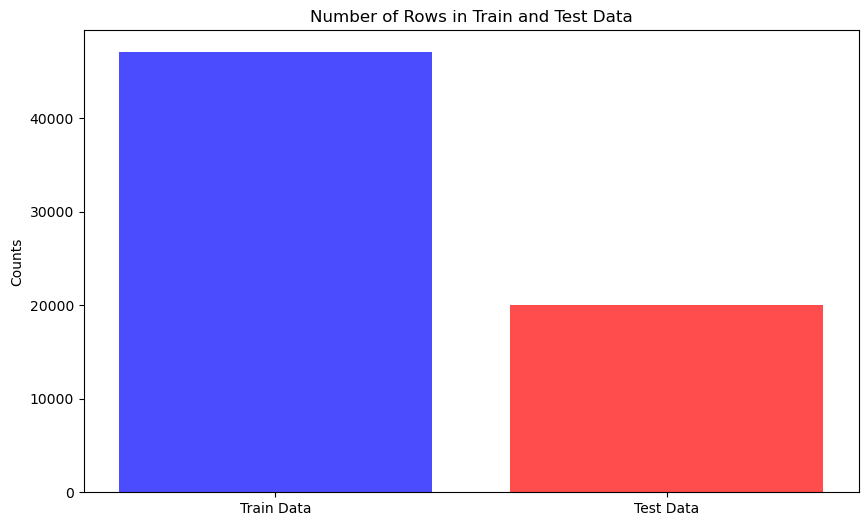

In [77]:
# Count the number of rows in each set
train_count = train_data.count()
test_count = test_data.count()

# Counts and labels for plotting
counts = [train_count, test_count]
labels = ['Train Data', 'Test Data']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['blue', 'red'], alpha=0.7)
plt.ylabel('Counts')
plt.title('Number of Rows in Train and Test Data')
plt.show()

In [81]:
rfc = RandomForestClassifier(featuresCol="features", labelCol="cardio", 
                             numTrees=100, maxDepth=10, seed=42, impurity="entropy")

In [82]:
rfc_model = rfc.fit(train_data)

23/10/07 12:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
23/10/07 12:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1801.8 KiB
23/10/07 12:51:11 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/10/07 12:51:11 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
23/10/07 12:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1224.5 KiB
23/10/07 12:51:12 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
23/10/07 12:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1823.7 KiB


In [83]:
rfc_predictions = rfc_model.transform(test_data)

<Figure size 1200x800 with 0 Axes>

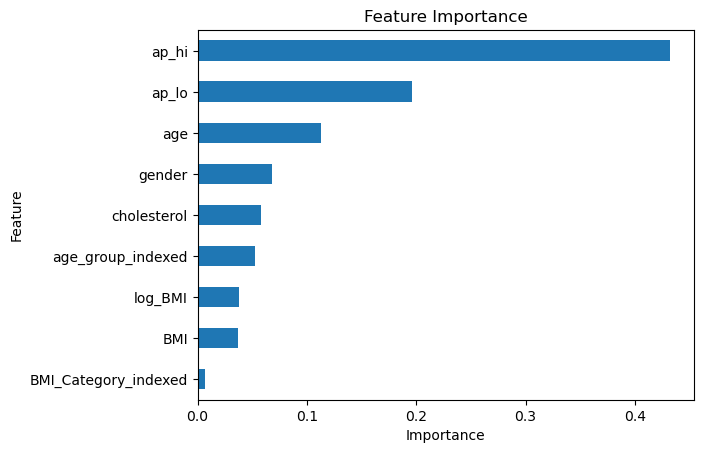

In [84]:
importances = rfc_model.featureImportances.toArray()

feature_names = assembler.getInputCols()

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importance = df_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
df_importance.set_index('feature').plot(kind='barh', legend=False)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [88]:
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'cardio')

In [89]:
# This is the area under the curve. This indicates that the data is highly seperable.
print("Random Forest")
print(my_binary_eval.evaluate(rfc_predictions))

Random Forest


23/10/07 12:52:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


0.7899577545667357


In [90]:
# Select (prediction, true label) and compute test error. 
acc_evaluator = MulticlassClassificationEvaluator(labelCol="cardio", predictionCol="prediction", metricName="accuracy")

In [91]:
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))

23/10/07 12:52:31 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


A random forest ensemble has an accuracy of: 72.02%


In [92]:

rfc_auc = my_binary_eval.evaluate(rfc_predictions, {my_binary_eval.metricName: "areaUnderROC"})

# Area Under PR Curve
rfc_pr =my_binary_eval.evaluate(rfc_predictions, {my_binary_eval.metricName: "areaUnderPR"})

# Weighted Precision
rfc_weighted_precision = acc_evaluator.evaluate(rfc_predictions, {acc_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
rfc_weighted_recall = acc_evaluator.evaluate(rfc_predictions, {acc_evaluator.metricName: "weightedRecall"})

# F1 Score
rfc_f1 = acc_evaluator.evaluate(rfc_predictions, {acc_evaluator.metricName: "f1"})


# Create a confusion matrix
rfc_true_positives = rfc_predictions.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
rfc_true_negatives = rfc_predictions.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
rfc_false_positives = rfc_predictions.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
rfc_false_negatives = rfc_predictions.filter((col("cardio") == 1) & (col("prediction") == 0)).count()

print('Random Forest Algorithm')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(rfc_true_positives, rfc_false_positives))
print("Predicted Negative\t{}\t\t{}".format(rfc_false_negatives, rfc_true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {rfc_auc}")
print(f"Area Under PR Curve: {rfc_pr}")
print(f"Accuracy: {rfc_acc}")
print(f"Weighted Precision: {rfc_weighted_precision}")
print(f"Weighted Recall: {rfc_weighted_recall}")
print(f"F1 Score: {rfc_f1}")

23/10/07 12:52:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/07 12:52:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/10/07 12:52:38 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/07 12:52:38 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/07 12:52:39 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/07 12:52:39 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/07 12:52:40 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/07 12:52:41 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/10/07 12:52:41 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


Random Forest Algorithm
Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	6465		2208
Predicted Negative	3379		7913
----------------------------------------
Area Under ROC (AUC): 0.7899553155698616
Area Under PR Curve: 0.7669528313890972
Accuracy: 0.720160280490859
Weighted Precision: 0.7227794265219225
Weighted Recall: 0.720160280490859
F1 Score: 0.7189635766905575


In [93]:
dtc = DecisionTreeClassifier(
    labelCol='cardio',
    featuresCol='features',
    maxDepth=10,
    minInstancesPerNode=2,
    minInfoGain=0.0
)
dtc_model = dtc.fit(train_data)
dtc_predictions = dtc_model.transform(test_data)
print("Decision Tree Algorithm")
print(my_binary_eval.evaluate(dtc_predictions))

Decision Tree Algorithm
0.6521127022515575


In [94]:
dtc_auc = my_binary_eval.evaluate(dtc_predictions, {my_binary_eval.metricName: "areaUnderROC"})

# Area Under PR Curve
dtc_pr =my_binary_eval.evaluate(dtc_predictions, {my_binary_eval.metricName: "areaUnderPR"})

# Weighted Precision
dtc_weighted_precision = acc_evaluator.evaluate(dtc_predictions, {acc_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
dtc_weighted_recall = acc_evaluator.evaluate(dtc_predictions, {acc_evaluator.metricName: "weightedRecall"})

# F1 Score
dtc_f1 = acc_evaluator.evaluate(dtc_predictions, {acc_evaluator.metricName: "f1"})

#Accuracy
dtc_acc = acc_evaluator.evaluate(dtc_predictions)

# Create a confusion matrix
dtc_true_positives = dtc_predictions.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
dtc_true_negatives = dtc_predictions.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
dtc_false_positives = dtc_predictions.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
dtc_false_negatives = dtc_predictions.filter((col("cardio") == 1) & (col("prediction") == 0)).count()

print('Decision Tree Algorithm')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(dtc_true_positives, dtc_false_positives))
print("Predicted Negative\t{}\t\t{}".format(dtc_false_negatives, dtc_true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {dtc_auc}")
print(f"Area Under PR Curve: {dtc_pr}")
print(f"Accuracy: {dtc_acc}")
print(f"Weighted Precision: {dtc_weighted_precision}")
print(f"Weighted Recall: {dtc_weighted_recall}")
print(f"F1 Score: {dtc_f1}")

Decision Tree Algorithm
Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	6469		2300
Predicted Negative	3375		7821
----------------------------------------
Area Under ROC (AUC): 0.6521127022515575
Area Under PR Curve: 0.6809649288692623
Accuracy: 0.7157525669922364
Weighted Precision: 0.7178610714687556
Weighted Recall: 0.7157525669922364
F1 Score: 0.7147113548006196


In [95]:
results = dtc_model.transform(test_data)

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='cardio')

results.select('cardio','prediction').show(15)


+------+----------+
|cardio|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       1.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       1.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 15 rows



In [96]:
totalResults = results.select('cardio','prediction')

correctResults = totalResults.filter(totalResults['cardio'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

Correct: 19965
Total Correct: 14290


<Figure size 1200x800 with 0 Axes>

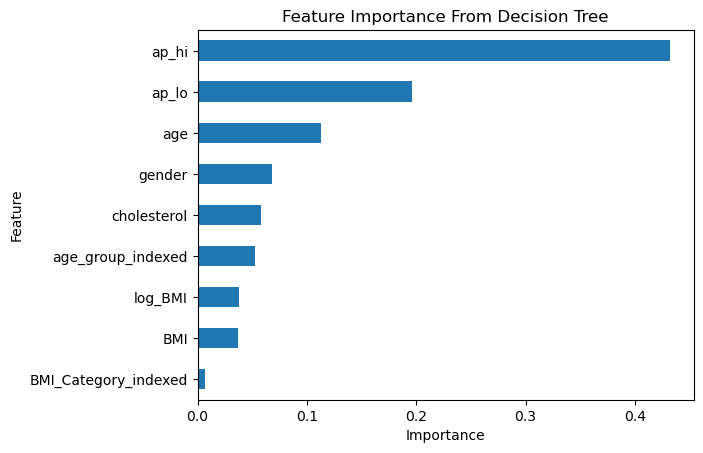

In [97]:
dtc_importances = dtc_model.featureImportances.toArray()

dtc_df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dtc_importances
})

dtc_df_importance = dtc_df_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
df_importance.set_index('feature').plot(kind='barh', legend=False)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.title('Feature Importance From Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [98]:
def replace_feature_indices_with_names(tree_string, feature_names):
    for i, feature_name in enumerate(feature_names):
        tree_string = tree_string.replace(f'feature {i}', feature_name)
    return tree_string


# Replace feature indices in the tree's string representation
tree_with_feature_names = replace_feature_indices_with_names(dtc_model.toDebugString, feature_names)

print(tree_with_feature_names)  # This will print the tree with feature names instead of indices


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_271870f8b969, depth=10, numNodes=703, numClasses=2, numFeatures=9
  If (ap_hi <= 129.75)
   If (age <= 54.5)
    If (age <= 44.5)
     If (cholesterol <= 1.5)
      If (ap_hi <= 119.5)
       If (log_BMI <= 3.2226686032580347)
        If (gender <= 0.5)
         Predict: 0.0
        Else (gender > 0.5)
         If (ap_lo <= 85.75)
          Predict: 0.0
         Else (ap_lo > 85.75)
          If (ap_hi <= 109.5)
           Predict: 1.0
          Else (ap_hi > 109.5)
           Predict: 0.0
       Else (log_BMI > 3.2226686032580347)
        If (age <= 41.5)
         If (gender <= 1.5)
          Predict: 0.0
         Else (gender > 1.5)
          If (age <= 40.5)
           Predict: 0.0
          Else (age > 40.5)
           If (log_BMI <= 3.3083507644039836)
            Predict: 0.0
           Else (log_BMI > 3.3083507644039836)
            Predict: 1.0
        Else (age > 41.5)
         If (log_BMI <= 3.498475218226593)
      

In [99]:
import re
from graphviz import Digraph

def visualize_tree(tree_string):
    graph = Digraph('DecisionTree', node_attr={'shape': 'box'})
    lines = tree_string.split("\n")
    
    for line in lines:
        if "feature" in line or "Predict" in line:
            match = re.search(r"(DecisionTree_[0-9]+) => (DecisionTree_[0-9]+) \[label=\"(.*? <= .*?)\"\]", line)
            if match:
                parent, child, label = match.groups()
                graph.edge(parent, child, label=label)
                
            match = re.search(r"(DecisionTree_[0-9]+) \[label=\"(Predict: .*?)\"\]", line)
            if match:
                node, label = match.groups()
                graph.node(node, label=label)

    return graph

In [131]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [100]:
tree_visualization = visualize_tree(tree_with_feature_names)
tree_visualization.view()


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

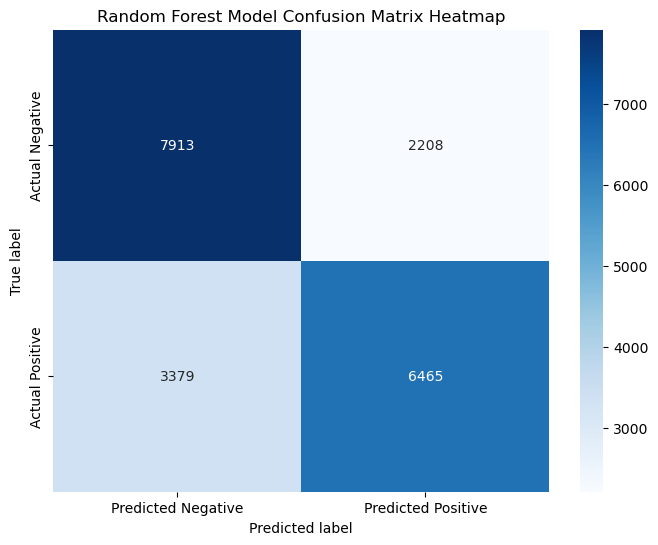

In [102]:
import seaborn as sns

confusion_matrix = [
    [rfc_true_negatives, rfc_false_positives],
    [rfc_false_negatives, rfc_true_positives]
]

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Random Forest Model Confusion Matrix Heatmap')
plt.show()


23/10/07 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


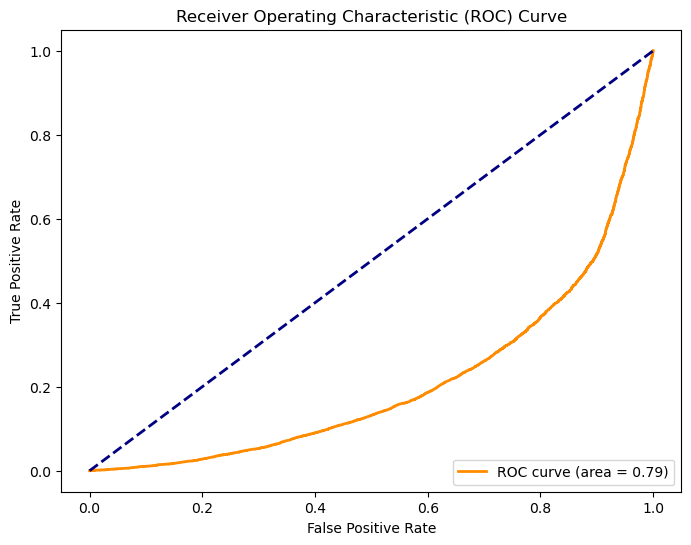

In [103]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve, auc

results = rfc_predictions.select(['probability', 'cardio']).collect()
results_list = [(float(i[0][0]), float(i[1])) for i in results]
y_score, y_true = zip(*results_list)
fpr, tpr, _ = roc_curve(y_true, y_score)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % rfc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


23/10/07 13:28:17 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


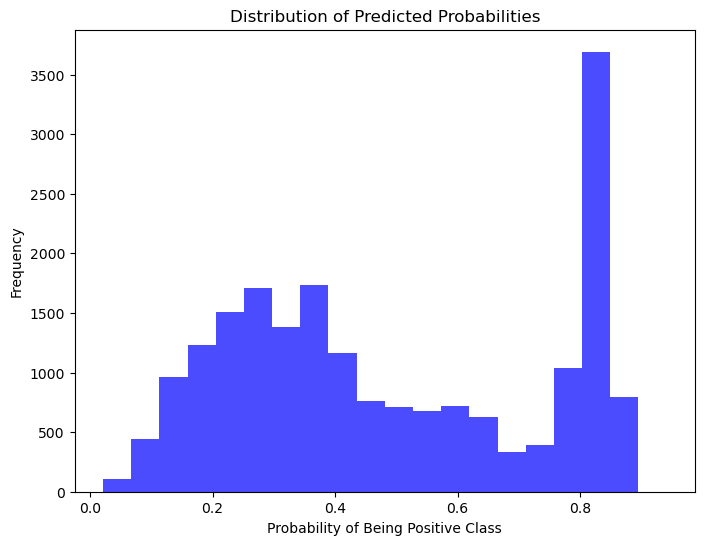

In [104]:
probabilities = rfc_predictions.select("probability").rdd.map(lambda x: x[0][1]).collect()

plt.figure(figsize=(8,6))
plt.hist(probabilities, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Being Positive Class')
plt.ylabel('Frequency')
plt.show()

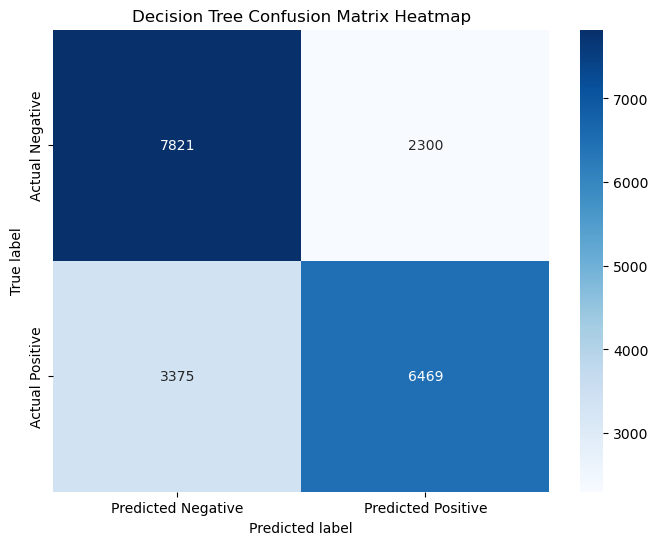

In [107]:
import seaborn as sns

confusion_matrix = [
    [dtc_true_negatives, dtc_false_positives],
    [dtc_false_negatives, dtc_true_positives]
]

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Decision Tree Confusion Matrix Heatmap')
plt.show()


In [106]:
import graphviz

def parse_to_dot(tree_str, feature_names):
    lines = tree_str.split("\n")
    dot_str = 'digraph Tree {\n'
    
    for line in lines:
        if line.startswith("If"):
            depth = line.count('  ')
            feature_index = int(line.split(' ')[1].split('_')[1])
            threshold = float(line.split('<=')[1])
            parent = 'node' + str(depth)
            dot_str += f'    "{parent}" [label="{feature_names[feature_index]} <= {threshold:.2f}"];\n'
            dot_str += f'    "{parent}" -> "node{depth + 1}L" [label="True"];\n'
            dot_str += f'    "{parent}" -> "node{depth + 1}R" [label="False"];\n'
        elif "Predict" in line:
            depth = line.count('  ')
            prediction = float(line.split(":")[1].strip())
            dot_str += f'    "node{depth}L" [label="Predict: {prediction}", shape=box];\n'
            dot_str += f'    "node{depth}R" [label="Predict: {prediction}", shape=box];\n'
    
    dot_str += '}'
    return dot_str

# Generate the DOT format string
dot_data = parse_to_dot(dtc_model.toDebugString, feature_names)

# Visualize using graphviz
graph = graphviz.Source(dot_data)
graph.view()


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [111]:
# Split the training and testing set.
train_data_iteration,test_data_iteration = final_data.randomSplit([0.8,0.2])

In [113]:
rfc_model_Iteration = rfc.fit(train_data_iteration)
rfc_predictions_Iteration = rfc_model.transform(test_data_iteration)

23/10/07 14:02:09 WARN DAGScheduler: Broadcasting large task binary with size 1014.2 KiB
23/10/07 14:02:09 WARN DAGScheduler: Broadcasting large task binary with size 1816.6 KiB
23/10/07 14:02:10 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/07 14:02:11 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
23/10/07 14:02:12 WARN DAGScheduler: Broadcasting large task binary with size 1280.4 KiB
23/10/07 14:02:12 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
23/10/07 14:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1925.3 KiB


In [115]:
rfcI_auc = my_binary_eval.evaluate(rfc_predictions_Iteration, {my_binary_eval.metricName: "areaUnderROC"})

# Area Under PR Curve
rfcI_pr =my_binary_eval.evaluate(rfc_predictions_Iteration, {my_binary_eval.metricName: "areaUnderPR"})

# Weighted Precision
rfcI_weighted_precision = acc_evaluator.evaluate(rfc_predictions_Iteration, {acc_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
rfcI_weighted_recall = acc_evaluator.evaluate(rfc_predictions_Iteration, {acc_evaluator.metricName: "weightedRecall"})

# F1 Score
rfcI_f1 = acc_evaluator.evaluate(rfc_predictions_Iteration, {acc_evaluator.metricName: "f1"})

#Accuracy
rfcI_acc = acc_evaluator.evaluate(rfc_predictions_Iteration)

# Create a confusion matrix
rfcI_true_positives = rfc_predictions_Iteration.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
rfcI_true_negatives = rfc_predictions_Iteration.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
rfcI_false_positives = rfc_predictions_Iteration.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
rfcI_false_negatives = rfc_predictions_Iteration.filter((col("cardio") == 1) & (col("prediction") == 0)).count()

print('Random Forest Algorithm')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(rfc_true_positives, rfc_false_positives))
print("Predicted Negative\t{}\t\t{}".format(rfc_false_negatives, rfc_true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {rfcI_auc}")
print(f"Area Under PR Curve: {rfcI_pr}")
print(f"Accuracy: {rfcI_acc}")
print(f"Weighted Precision: {rfcI_weighted_precision}")
print(f"Weighted Recall: {rfcI_weighted_recall}")
print(f"F1 Score: {rfcI_f1}")

23/10/07 14:04:33 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:33 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:34 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:35 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:35 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:36 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:36 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:37 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:37 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:04:38 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


Random Forest Algorithm
Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	6465		2208
Predicted Negative	3379		7913
----------------------------------------
Area Under ROC (AUC): 0.8004468215523884
Area Under PR Curve: 0.7782061536991369
Accuracy: 0.735518465372706
Weighted Precision: 0.737529397505601
Weighted Recall: 0.735518465372706
F1 Score: 0.7345292189158306


In [116]:
assembler_Iteration = VectorAssembler(
    inputCols=["age", "gender","ap_hi","ap_lo",
               "cholesterol","age_group_indexed"],
    outputCol="features")
output_I = assembler.transform(combined_df_indexed)
final_data_Iteration = output.select("features",'cardio')
final_data_Iteration.show()

+--------------------+------+
|            features|cardio|
+--------------------+------+
|[50.0,2.0,110.0,8...|     0|
|[55.0,1.0,140.0,9...|     1|
|[52.0,1.0,130.0,7...|     1|
|[48.0,2.0,150.0,1...|     1|
|[48.0,1.0,100.0,6...|     0|
|[60.0,1.0,120.0,8...|     0|
|[61.0,1.0,130.0,8...|     0|
|[62.0,2.0,130.0,9...|     1|
|[48.0,1.0,110.0,7...|     0|
|[54.0,1.0,110.0,6...|     0|
|[62.0,1.0,120.0,8...|     0|
|[52.0,2.0,120.0,8...|     0|
|[41.0,2.0,120.0,8...|     0|
|[54.0,1.0,110.0,7...|     0|
|[40.0,2.0,130.0,9...|     0|
|[46.0,2.0,120.0,8...|     1|
|[58.0,1.0,130.0,7...|     0|
|[46.0,1.0,110.0,7...|     0|
|[48.0,1.0,100.0,7...|     0|
|[60.0,2.0,120.0,7...|     0|
+--------------------+------+
only showing top 20 rows



In [117]:
train_data_iteration2,test_data_iteration2 = final_data_Iteration.randomSplit([0.8,0.2])

In [119]:
rfc_model_Iteration2 = rfc.fit(train_data_iteration2)
rfc_predictions_Iteration2 = rfc_model.transform(test_data_iteration2)


23/10/07 14:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
23/10/07 14:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1813.1 KiB
23/10/07 14:27:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/10/07 14:27:09 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
23/10/07 14:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1269.5 KiB
23/10/07 14:27:10 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
23/10/07 14:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1904.3 KiB


In [120]:
rfcI2_auc = my_binary_eval.evaluate(rfc_predictions_Iteration2, {my_binary_eval.metricName: "areaUnderROC"})

# Area Under PR Curve
rfcI2_pr =my_binary_eval.evaluate(rfc_predictions_Iteration2, {my_binary_eval.metricName: "areaUnderPR"})

# Weighted Precision
rfcI2_weighted_precision = acc_evaluator.evaluate(rfc_predictions_Iteration2, {acc_evaluator.metricName: "weightedPrecision"})

# Weighted Recall
rfcI2_weighted_recall = acc_evaluator.evaluate(rfc_predictions_Iteration2, {acc_evaluator.metricName: "weightedRecall"})

# F1 Score
rfcI2_f1 = acc_evaluator.evaluate(rfc_predictions_Iteration2, {acc_evaluator.metricName: "f1"})

#Accuracy
rfcI2_acc = acc_evaluator.evaluate(rfc_predictions_Iteration2)

# Create a confusion matrix
rfcI_true_positives = rfc_predictions_Iteration.filter((col("cardio") == 1) & (col("prediction") == 1)).count()
rfcI_true_negatives = rfc_predictions_Iteration.filter((col("cardio") == 0) & (col("prediction") == 0)).count()
rfcI_false_positives = rfc_predictions_Iteration.filter((col("cardio") == 0) & (col("prediction") == 1)).count()
rfcI_false_negatives = rfc_predictions_Iteration.filter((col("cardio") == 1) & (col("prediction") == 0)).count()

print('Random Forest Algorithm')
print("Confusion Matrix:")
print("\t\tActual Positive\tActual Negative")
print("Predicted Positive\t{}\t\t{}".format(rfc_true_positives, rfc_false_positives))
print("Predicted Negative\t{}\t\t{}".format(rfc_false_negatives, rfc_true_negatives))
print('-'*40)

print(f"Area Under ROC (AUC): {rfcI2_auc}")
print(f"Area Under PR Curve: {rfcI2_pr}")
print(f"Accuracy: {rfcI2_acc}")
print(f"Weighted Precision: {rfcI2_weighted_precision}")
print(f"Weighted Recall: {rfcI2_weighted_recall}")
print(f"F1 Score: {rfcI2_f1}")

23/10/07 14:27:30 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:30 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:31 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:32 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:32 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:33 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:33 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:34 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:34 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/10/07 14:27:35 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


Random Forest Algorithm
Confusion Matrix:
		Actual Positive	Actual Negative
Predicted Positive	6465		2208
Predicted Negative	3379		7913
----------------------------------------
Area Under ROC (AUC): 0.8130467387180563
Area Under PR Curve: 0.8028645064705227
Accuracy: 0.7368186543888311
Weighted Precision: 0.7388746232841588
Weighted Recall: 0.7368186543888311
F1 Score: 0.7358231344997237
